### Problem Set 5, due Nov 5 at 11:59pm

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early!

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import IPython

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's [Oscar winner](https://www.rottentomatoes.com/m/the_shape_of_water_2017) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
#IPython.embed()

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [3]:
# enter your code below

print("Number of reviews: {}".format(len(reviews)))
print("Number of unique reviews are: {}".format(len(reviews['quote'].unique())))
print("Number of critic: {}".format(len(reviews.critic.unique())))
print("Number of Movies in reviews: {}".format(len(reviews.imdb.unique())))
print("Number of Movies in movies: {}".format(len(movies.title.unique())))
print("Number of Publication in reviews df: {}".format(len(reviews.publication.unique())))

Number of reviews: 13419
Number of unique reviews are: 12814
Number of critic: 541
Number of Movies in reviews: 1720
Number of Movies in movies: 9405
Number of Publication in reviews df: 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviewers.  Label your axes and make your histogram look professional.

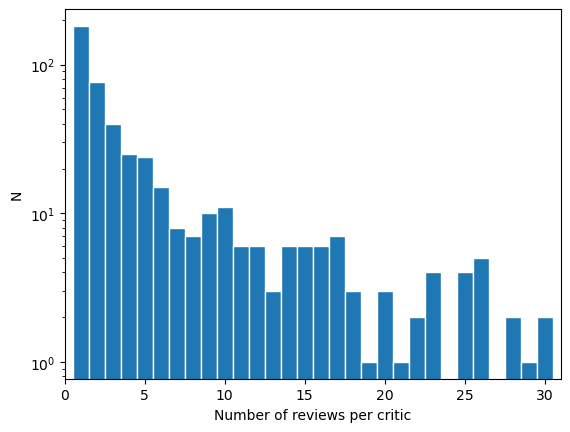

In [4]:
plt.style.use('default')

rev_per = reviews.groupby('critic').rtid.count()
rev_per.hist(log=True, bins=np.arange(.5, 31, 1), edgecolor='white')
plt.xlabel("Number of reviews per critic")
plt.ylabel("N")
plt.xlim([0, 31])
plt.grid(False)

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [5]:
# enter your code here
reviewer_top_30 = rev_per.sort_values(ascending=False)[:30].index.tolist()
review_top_30 = reviews[reviews.critic.isin(reviewer_top_30)]
reviewer_group_1 = review_top_30.groupby(['critic','publication']).size().reset_index()
reviewer_group_2 = reviewer_group_1.groupby('critic').apply(lambda x: ', '.join(x['publication'])).reset_index()
reviewer_group_2.columns = ['critic', 'publication']
review_date = review_top_30.groupby('critic')['review_date'].agg(first_review='min', last_review='max').reset_index()
review_date.merge(reviewer_group_2, on='critic', how='inner')[['critic', 'publication', 'first_review', 'last_review']]

,critic,publication,first_review,last_review
0,Bosley Crowther,New York Times,2000-01-01 00:00:00,2008-05-06 00:00:00
1,Dave Kehr,"Chicago Reader, Chicago Tribune, New York Dail...",2000-01-01 00:00:00,2013-11-20 00:00:00
2,Derek Adams,Time Out,2006-01-26 00:00:00,2009-10-04 00:00:00
3,Desson Thomson,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00
4,Edward Guthmann,San Francisco Chronicle,2000-01-01 00:00:00,2003-04-04 00:00:00
5,Emanuel Levy,Variety,2000-01-01 00:00:00,2010-08-06 00:00:00
6,Geoff Andrew,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00
7,Hal Hinson,Washington Post,2000-01-01 00:00:00,2013-06-26 00:00:00
8,James Berardinelli,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00
9,Janet Maslin,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

c:\users\dimitris\miniconda3\envs\drl2\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


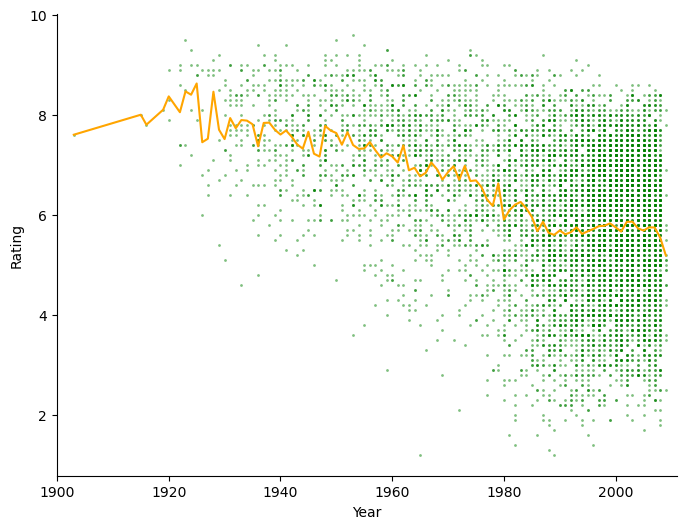

In [6]:
# enter your code here
movies_2 = movies[movies.rtAllCriticsRating != '\\N']
movies_2.loc[:,'rtAllCriticsRating'] = movies_2['rtAllCriticsRating'].astype(float)
movies_2 = movies_2[movies_2.rtAllCriticsRating > 0]

a = movies_2.groupby('year')['rtAllCriticsRating'].mean()
movies_3 = pd.DataFrame({'year': a.index.tolist(), 'avg_rate': a.tolist()})
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(movies_2['year'], movies_2['rtAllCriticsRating'], 'o', c='g', markersize=2, markeredgecolor='none', alpha=0.5)
ax.plot(movies_3['year'], movies_3['avg_rate'], '-', c='orange')
plt.xlabel('Year')
plt.ylabel('Rating')
ax.set_xlim(1900,2011)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

*enter your observations here*

This graph shows a trend towards a lower average score, as well as a greater abundance of low scores, with time. This is probably at least partially a selection effect -- Rotten Tomatoes probably doesn't archive reviews for all movies, especially ones that came out before the website existed. Thus, reviews of old movies are more often "the classics". Mediocre old movies have been partially forgotten, and are underrepresented in the data.

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))
print()
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("Transformed text vector is \n", x)
print()
# `get_feature_names` tracks which word is associated with each column of the transformed x
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [8]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    #Your code here 
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(reviews.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    Y = (reviews.fresh == 'fresh').values.astype(np.int)
    return X, Y


In [9]:
X, Y = make_xy(reviews)

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set (80%) and a validation set (20%).  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [10]:
# enter your code here
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
print(xtrain.shape, xtest.shape)
print(xtest.shape,ytest.shape)

(10735, 20875) (2684, 20875)
(2684, 20875) (2684,)


### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [11]:
# enter your code here

# call the fitted model fitted_model, for future reference:
clf = MultinomialNB()
fitted_model = clf.fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:.2f}".format(training_accuracy))
print("Accuracy on test data: {:.2f}".format(test_accuracy))

Accuracy on training data: 0.92
Accuracy on test data: 0.79


*enter your observations here*

Some overfitting seems to be happening here, since the error rate on the test data is more than twice as large as the error rate on the training data . It's possible (though unlikely) that the accuracy difference is a product of chance, and not a symptom of overfitting. This could be tested with cross-validation, by repeatedly fitting and scoring the classifier on different train/test splits. If the performance on the training data is consistently better than the test data, then overfitting has occured. This is the case here.

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on bcourses).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [12]:
# Your code here
# check the solution in the link by Krishnamurthy Viswanathan

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [13]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# change the names of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, xtest, ytest)

-1442.899052206324

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [ ]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        #your code here
        clf = MultinomialNB(alpha=alpha)
        clf.fit(X, Y)
        loglike = log_likelihood(clf, X, Y)
        print("alpha: {:.2f}, min_df: {:.6f}, L: {:.2f}".format(alpha, min_df, loglike))
        
        if loglike > max_loglike:
            max_loglike = loglike
            best_alpha, best_min_df = alpha, min_df     

print("best alpha: {:.2f}, best min_dfs: {:.5f}".format(best_alpha, best_min_df))

c:\users\dimitris\miniconda3\envs\drl2\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


alpha: 0.00, min_df: 0.000010, L: -1522.87


c:\users\dimitris\miniconda3\envs\drl2\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


alpha: 0.00, min_df: 0.000100, L: -2626.41


c:\users\dimitris\miniconda3\envs\drl2\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


alpha: 0.00, min_df: 0.001000, L: -6018.99


c:\users\dimitris\miniconda3\envs\drl2\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


alpha: 0.00, min_df: 0.010000, L: -8114.11


c:\users\dimitris\miniconda3\envs\drl2\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


alpha: 0.00, min_df: 0.100000, L: -8701.37
alpha: 0.10, min_df: 0.000010, L: -1851.60
alpha: 0.10, min_df: 0.000100, L: -2852.96
alpha: 0.10, min_df: 0.001000, L: -6016.62
alpha: 0.10, min_df: 0.010000, L: -8113.92
alpha: 0.10, min_df: 0.100000, L: -8701.37
alpha: 1.00, min_df: 0.000010, L: -2736.24
alpha: 1.00, min_df: 0.000100, L: -3393.18


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [ ]:
#Enter your code here

vectorizer = CountVectorizer(min_df=best_min_df)
X, Y = make_xy(reviews, vectorizer)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:.2f}".format(training_accuracy))
print("Accuracy on test data: {:.2f}".format(test_accuracy))

*enter your observations here*

It is interesting to note that the accuracy in both the test and train cases with hyper parameter selection using cross validation is lower than the case without cross validation. Furthermore, changes in alpha are not creating a lot of impact on the scores. One reason for lower accuracy can be that the methods in the 2.1-2.3 are not using log likelihood scoring rather the default scoring method is used which may be more suitable (overfitting) to this dataset

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [ ]:
#Enter your code here
best_alpha2 = None
best_min_df2 = None
max_loglike2 = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        #your code here
        clf = MultinomialNB(alpha=alpha)
        loglike = cross_val_score(clf, X, Y, scoring="accuracy").mean()
        print(loglike)
        print("alpha: {:.2f}, min_df: {:.2f}, L: {:.2f}".format(alpha, min_df, loglike))
        
        if loglike > max_loglike2:
            max_loglike2 = loglike
            best_alpha2, best_min_df2 = alpha, min_df   

In [ ]:
print("best alpha: {:.2f}, best min_dfs: {:.2f}".format(best_alpha2, best_min_df2))

In [ ]:
vectorizer = CountVectorizer(min_df=best_min_df2)
X, Y = make_xy(reviews, vectorizer)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

clf = MultinomialNB(alpha=best_alpha2).fit(xtrain, ytrain)
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:.2f}".format(training_accuracy))
print("Accuracy on test data: {:.2f}".format(test_accuracy))

*enter your observations here*

In this case the accuracy on test and train data by selecting hyperparameters based on best likelihood is outperforming the case when hyper parameters were selected using the accuracy function. Methods like naive bayes are very much prone to overfitting so hyper parameter tuning may be overfitting.

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [ ]:
# Enter your code here
words = np.array(vectorizer.get_feature_names())

x = np.identity(xtest.shape[1])

probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\tP(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:20s}\t{:.2f}".format(w, 1 - np.exp(p)))
    
print("Bad words\tP(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:20s}\t{:.2f}".format(w, 1 - np.exp(p)))

*enter your observations here*

The ten words predicting rotten review and the 10 words predicting fresh reveiws make sense. The rotten reviews usually cover negative words, while fresh reviews cover positive words.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [ ]:
#Your code here
x, y = make_xy(reviews, vectorizer)

prob = clf.predict_proba(x)[:, 0]
IPython.embed()
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(reviews[y == 0].reset_index()['quote'][row])
    print()

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(reviews[y == 1].reset_index()['quote'][row])
    print()
    
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

Python 3.6.8 |Anaconda custom (64-bit)| (default, Dec 30 2018, 01:22:34) 
Type 'copyright', 'credits' or 'license' for more information
IPython 6.4.0 -- An enhanced Interactive Python. Type '?' for help.

In [1]: pron
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-1-24c9b30c0391> in <module>()
----> 1 pron

NameError: name 'pron' is not defined

In [2]: prob
Out[2]: 
array([0.00093442, 0.11016312, 0.00605138, ..., 0.00187364, 0.25189835,
       0.03178189])

In [3]: clf.predict_proba(x)
Out[3]: 
array([[9.34417754e-04, 9.99065582e-01],
       [1.10163122e-01, 8.89836878e-01],
       [6.05138146e-03, 9.93948619e-01],
       ...,
       [1.87363749e-03, 9.98126363e-01],
       [2.51898348e-01, 7.48101652e-01],
       [3.17818852e-02, 9.68218115e-01]])



*Enter your observations here*

Many mis-predictions seem due to the fact that the quotes use more ambivalent language -- quotes along the lines of "this should have been a good movie, but it wasn't". Words like "but", "not", etc. act to negate the sentiment of words. However, because Naive Bayes treats each word separately, it isn't able to capture these kind of word interactions. Because the quote "this movie is not remarkable, touching, or superb in any way" contains typically positive words like remarkabke/touching/superb, the classifier gives it P(Fresh)=0.98.